In [1]:
# Setup
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Import all components
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2
from core.risk_manager import RiskManager, RiskConfig
from core.portfolio_manager import PortfolioManager, PortfolioConfig, run_multi_asset_backtest

print("✅ All imports successful")
print(f"   Project root: {project_root}")

✅ All imports successful
   Project root: /Users/Sakarias/QuantTrading


---

## System Architecture

```
┌─────────────────────────────────────────────────────────┐
│                 BACKTEST PIPELINE                       │
└─────────────────────────────────────────────────────────┘

    1. LOAD DATA
    ↓
    [MultiAssetLoader]
    ├─ ES: yfinance → DataFrame
    ├─ GC: yfinance → DataFrame
    └─ NQ: yfinance → DataFrame
    
    2. GENERATE SIGNALS
    ↓
    [MultiAssetSignal]
    ├─ MomentumSignalV2(ES) → {Signal, SMA_200, ...}
    ├─ MomentumSignalV2(GC) → {Signal, SMA_200, ...}
    └─ MomentumSignalV2(NQ) → {Signal, SMA_200, ...}
    
    3. RISK MANAGEMENT
    ↓
    [RiskManager]
    ├─ Calculate volatility
    ├─ Calculate correlation
    ├─ Adjust position sizes
    └─ Monitor drawdown
    
    4. PORTFOLIO EXECUTION
    ↓
    [PortfolioManager]
    ├─ Initialize positions
    ├─ For each day:
    │   ├─ Update prices
    │   ├─ Check signals
    │   ├─ Execute trades
    │   └─ Record equity
    └─ Calculate metrics
    
    5. RESULTS
    ↓
    [BacktestResult]
    ├─ Equity curve
    ├─ Trades log
    ├─ Performance metrics
    └─ Risk statistics
```

---

## Step 1: Load Data

**Source:** `core/multi_asset_loader.py` → `load_assets()`

**What happens:**
1. Downloads data from yfinance
2. Validates date ranges
3. Checks for missing data
4. Returns dictionary of DataFrames

In [2]:
# Configuration
TICKERS = ['ES', 'GC', 'NQ']
START_DATE = '2024-01-01'
END_DATE = '2025-11-26'

print("\n📊 STEP 1: Loading Data")
print(f"   Tickers: {TICKERS}")
print(f"   Period: {START_DATE} to {END_DATE}")

# Load data
prices = load_assets(
    tickers=TICKERS,
    start_date=START_DATE,
    end_date=END_DATE
)

print("\n✅ Data Loaded:")
for ticker, df in prices.items():
    print(f"   {ticker}:")
    print(f"      Rows: {len(df)}")
    print(f"      Columns: {list(df.columns)}")
    print(f"      Date range: {df.index[0].date()} to {df.index[-1].date()}")
    print(f"      Missing values: {df.isnull().sum().sum()}")
    print()


📊 STEP 1: Loading Data
   Tickers: ['ES', 'GC', 'NQ']
   Period: 2024-01-01 to 2025-11-26

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 

---

## Step 2: Generate Signals

**Source:** `signals/momentum.py` → `MomentumSignalV2`

**Logic:**
```python
# For each asset:
momentum = (price / price.shift(lookback)) - 1
sma_200 = price.rolling(200).mean()

signal = 1 if momentum > 0 and price > sma_200 else 0
```

In [3]:
print("\n🎯 STEP 2: Generating Signals")

# Create signal generator
signal_gen = MomentumSignalV2(
    lookback=120,      # 120-day momentum
    sma_filter=200     # 200-day trend filter
)

# Wrap for multi-asset
multi_signal = SingleAssetWrapper(signal_gen)

# Generate signals
signals = multi_signal.generate(prices)

print("\n✅ Signals Generated:")
for ticker in prices.keys():
    sig_df = signals[ticker]
    n_long = (sig_df['Signal'] == 1).sum()
    n_flat = (sig_df['Signal'] == 0).sum()
    
    print(f"   {ticker}:")
    print(f"      Total days: {len(sig_df)}")
    print(f"      Long: {n_long} days ({n_long/len(sig_df)*100:.1f}%)")
    print(f"      Flat: {n_flat} days ({n_flat/len(sig_df)*100:.1f}%)")
    print(f"      Current signal: {sig_df['Signal'].iloc[-1]}")
    print()


🎯 STEP 2: Generating Signals

✅ Signals Generated:
   ES:
      Total days: 480
      Long: 260 days (54.2%)
      Flat: 220 days (45.8%)
      Current signal: 1.0

   GC:
      Total days: 480
      Long: 260 days (54.2%)
      Flat: 220 days (45.8%)
      Current signal: 1.0

   NQ:
      Total days: 480
      Long: 260 days (54.2%)
      Flat: 220 days (45.8%)
      Current signal: 1.0



---

## Step 3: Configure Risk Management

**Source:** `core/risk_manager.py` → `RiskManager`

**Controls:**
- Position sizing (vol-adjusted)
- Drawdown stops
- Correlation limits

In [4]:
print("\n🛡️ STEP 3: Configuring Risk Management")

# Create risk configuration
risk_config = RiskConfig(
    max_position_size=0.35,        # 35% max per asset
    max_drawdown_stop=-0.20,       # -20% drawdown stop (negative!)
    position_sizing_method='vol_adjusted',
    volatility_target=0.15,        # 15% annual vol
    correlation_threshold=0.70,    # 70% correlation limit
    correlation_window=60          # 60 days
)

# Create risk manager
risk_manager = RiskManager(risk_config)

print("\n✅ Risk Manager Configured:")
print(f"   Max Position: {risk_config.max_position_size:.0%}")
print(f"   Max Drawdown Stop: {risk_config.max_drawdown_stop:.0%}")
print(f"   Sizing Method: {risk_config.position_sizing_method}")
print(f"   Target Vol: {risk_config.volatility_target:.0%}")
print(f"   Max Correlation: {risk_config.correlation_threshold:.0%}")


🛡️ STEP 3: Configuring Risk Management

✅ Risk Manager Configured:
   Max Position: 35%
   Max Drawdown Stop: -20%
   Sizing Method: vol_adjusted
   Target Vol: 15%
   Max Correlation: 70%


---

## Step 4: Configure Portfolio

**Source:** `core/portfolio_manager.py` → `PortfolioConfig`

**Settings:**
- Initial capital
- Rebalance threshold
- Transaction costs
- Risk manager integration

In [5]:
print("\n💼 STEP 4: Configuring Portfolio")

# Create portfolio configuration
portfolio_config = PortfolioConfig(
    initial_capital=100000,
    rebalance_threshold=0.15,      # 5% drift
    transaction_cost_bps=3.0,      # 3 basis points
    risk_manager=risk_manager      # Link risk manager
)

print("\n✅ Portfolio Configured:")
print(f"   Initial Capital: ${portfolio_config.initial_capital:,.0f}")
print(f"   Rebalance Threshold: {portfolio_config.rebalance_threshold:.1%}")
print(f"   Transaction Cost: {portfolio_config.transaction_cost_bps} bps")
print(f"   Risk Manager: {'Enabled' if portfolio_config.risk_manager else 'Disabled'}")


💼 STEP 4: Configuring Portfolio

✅ Portfolio Configured:
   Initial Capital: $100,000
   Rebalance Threshold: 15.0%
   Transaction Cost: 3.0 bps
   Risk Manager: Enabled


---

## Step 5: Run Backtest

**Source:** `backtest/backtest_engine.py` → `run_multi_asset_backtest()`

**What happens inside:**
```python
# 1. Initialize
pm = PortfolioManager(config)
initial_prices = {ticker: df.iloc[0] for ticker, df in prices.items()}
initial_signals = {ticker: df.iloc[0] for ticker, df in signals.items()}
pm.initialize_positions(initial_prices, initial_signals)

# 2. Loop through each day
for date in dates[1:]:
    # Update prices
    current_prices = {ticker: df.loc[date] for ticker, df in prices.items()}
    pm.update_positions(current_prices)
    
    # Update signals (triggers trades)
    current_signals = {ticker: df.loc[date] for ticker, df in signals.items()}
    pm.update_signals(current_signals, current_prices, date)
    
    # Check rebalance
    if pm.check_rebalance_needed(current_signals):
        pm.rebalance(current_prices, current_signals, date)
    
    # Record equity
    pm.record_equity(date)

# 3. Calculate metrics
result = pm.calculate_metrics()
```

In [6]:
# Debug: Check date alignment between prices and signals
print("\n🔍 DEBUG: Checking Date Alignment\n")

for ticker in prices.keys():
    price_dates = set(prices[ticker].index)
    signal_dates = set(signals[ticker].index)
    
    common_dates = price_dates & signal_dates
    
    print(f"{ticker}:")
    print(f"  Price dates: {len(price_dates)} (from {prices[ticker].index[0].date()} to {prices[ticker].index[-1].date()})")
    print(f"  Signal dates: {len(signal_dates)} (from {signals[ticker].index[0].date()} to {signals[ticker].index[-1].date()})")
    print(f"  Common dates: {len(common_dates)}")
    print(f"  Price has 'Close' column: {'Close' in prices[ticker].columns}")
    print(f"  Signal has 'Signal' column: {'Signal' in signals[ticker].columns}")
    print()

# Check for common dates across all tickers
all_common = None
for ticker in prices.keys():
    common = set(prices[ticker].index) & set(signals[ticker].index)
    if all_common is None:
        all_common = common
    else:
        all_common &= common

print(f"Common dates across ALL tickers: {len(all_common)}")
if len(all_common) > 0:
    sorted_dates = sorted(all_common)
    print(f"  Date range: {sorted_dates[0].date()} to {sorted_dates[-1].date()}")


🔍 DEBUG: Checking Date Alignment

ES:
  Price dates: 480 (from 2024-01-02 to 2025-11-26)
  Signal dates: 480 (from 2024-01-02 to 2025-11-26)
  Common dates: 480
  Price has 'Close' column: True
  Signal has 'Signal' column: True

GC:
  Price dates: 480 (from 2024-01-02 to 2025-11-26)
  Signal dates: 480 (from 2024-01-02 to 2025-11-26)
  Common dates: 480
  Price has 'Close' column: True
  Signal has 'Signal' column: True

NQ:
  Price dates: 480 (from 2024-01-02 to 2025-11-26)
  Signal dates: 480 (from 2024-01-02 to 2025-11-26)
  Common dates: 480
  Price has 'Close' column: True
  Signal has 'Signal' column: True

Common dates across ALL tickers: 480
  Date range: 2024-01-02 to 2025-11-26


In [8]:
print("\n🚀 STEP 5: Running Backtest")
print("   This will simulate trading day-by-day...\n")

# Run backtest
result, equity_curve, trades = run_multi_asset_backtest(
    signals_dict=signals,
    prices_dict=prices,
    config=portfolio_config
)

print("\n✅ Backtest Complete!")
print(f"   Total days simulated: {len(equity_curve)}")
print(f"   Total trades executed: {len(trades)}")


🚀 STEP 5: Running Backtest
   This will simulate trading day-by-day...


✅ Backtest Complete!
   Total days simulated: 480
   Total trades executed: 3


In [10]:
# Debug: Check if there are risk violations
print("\n🔍 DEBUG: Checking Risk Manager State\n")

if result.violations is not None and len(result.violations) > 0:
    print("⚠️ RISK VIOLATIONS FOUND:")
    print(result.violations)
    print()
else:
    print("✅ No risk violations")
    print()

# Check equity curve details
equity_df = result.get_equity_curve()
print(f"Equity curve shape: {equity_df.shape}")
print(f"\nFirst few rows:")
print(equity_df.head())
print(f"\nLast few rows:")
print(equity_df.tail())


🔍 DEBUG: Checking Risk Manager State

✅ No risk violations

Equity curve shape: (480, 4)

First few rows:
        Date  TotalValue      Cash  \
0 2024-01-02    100000.0  100000.0   
1 2024-01-03    100000.0  100000.0   
2 2024-01-04    100000.0  100000.0   
3 2024-01-05    100000.0  100000.0   
4 2024-01-08    100000.0  100000.0   

                                           Positions  
0  {'ES': {'Shares': 0, 'Price': 4787.25, 'Value'...  
1  {'ES': {'Shares': 0, 'Price': 4746.5, 'Value':...  
2  {'ES': {'Shares': 0, 'Price': 4729.5, 'Value':...  
3  {'ES': {'Shares': 0, 'Price': 4734.75, 'Value'...  
4  {'ES': {'Shares': 0, 'Price': 4801.25, 'Value'...  

Last few rows:
          Date     TotalValue        Cash  \
475 2025-11-19  129782.418319  290.886237   
476 2025-11-20  128050.895533  290.886237   
477 2025-11-21  128939.334291  290.886237   
478 2025-11-24  130645.680607  290.886237   
479 2025-11-26  133237.627997  290.886237   

                                             Po

---

## Step 6: Analyze Results

**Performance Metrics**

In [11]:
print("\n📊 STEP 6: Performance Analysis")

metrics = result.calculate_metrics()

print("\n=== RETURNS ===")
print(f"Total Return: {metrics['Total Return']:.2%}")
print(f"Annual Return: {metrics['CAGR']:.2%}")
print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")

print("\n=== RISK ===")
print(f"Volatility: {metrics['Annual Volatility']:.2%}")
print(f"Max Drawdown: {metrics['Max Drawdown']:.2%}")

print("\n=== TRADING ===")
print(f"Total Trades: {metrics['Total Trades']}")
print(f"Rebalances: {metrics['Rebalances']}")
print(f"Total Costs: ${metrics['Transaction Costs']:,.2f}")
print(f"TC as % of Capital: {metrics['TC as % of Capital']:.2%}")


📊 STEP 6: Performance Analysis

=== RETURNS ===
Total Return: 33.24%
Annual Return: 16.26%
Sharpe Ratio: 1.39

=== RISK ===
Volatility: 11.32%
Max Drawdown: -12.21%

=== TRADING ===
Total Trades: 3
Rebalances: 0
Total Costs: $29.90
TC as % of Capital: 0.03%


---

## Step 7: Equity Curve Visualization

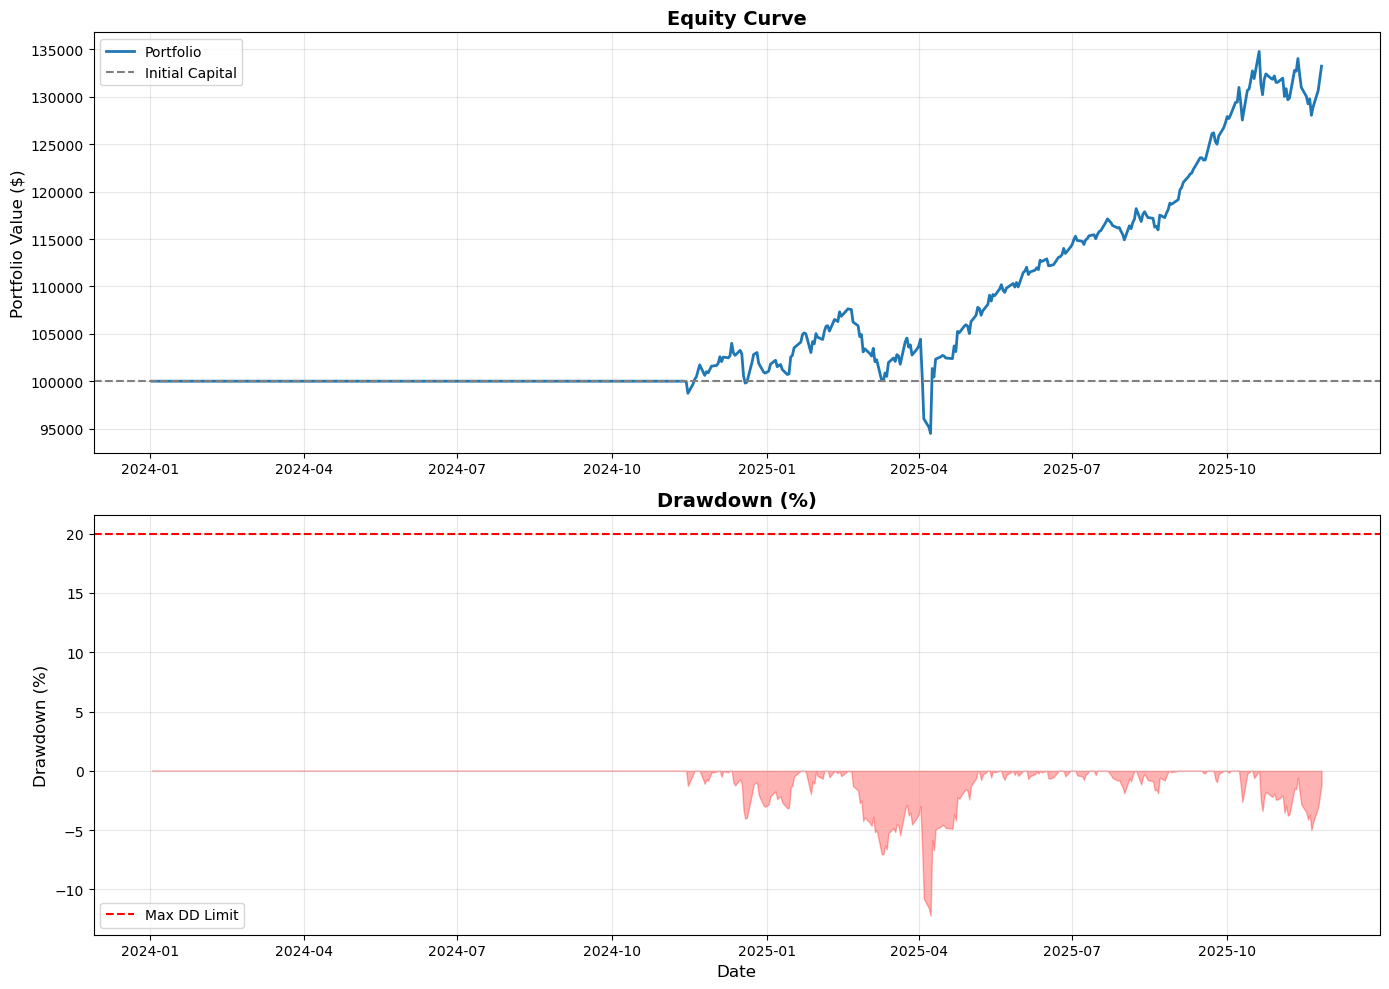


✅ Visualization Complete


In [12]:
# Plot equity curve
equity_df = result.get_equity_curve()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
axes[0].plot(equity_df['Date'], equity_df['TotalValue'], linewidth=2, label='Portfolio')
axes[0].axhline(y=portfolio_config.initial_capital, color='gray', linestyle='--', label='Initial Capital')
axes[0].set_title('Equity Curve', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drawdown
equity_df['Drawdown'] = (equity_df['TotalValue'] / equity_df['TotalValue'].cummax()) - 1
axes[1].fill_between(equity_df['Date'], equity_df['Drawdown'] * 100, 0, color='red', alpha=0.3)
axes[1].axhline(y=-risk_config.max_drawdown_stop * 100, color='red', linestyle='--', label='Max DD Limit')
axes[1].set_title('Drawdown (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization Complete")

---

## Step 8: Trade Analysis

In [13]:
# Analyze trades
trades_df = result.get_trades_df()

print("\n📝 Trade Analysis")
print(f"\nTotal Trades: {len(trades_df)}")

# Trades by ticker
print("\n=== TRADES BY TICKER ===")
for ticker in prices.keys():
    ticker_trades = trades_df[trades_df['Ticker'] == ticker]
    print(f"{ticker}: {len(ticker_trades)} trades")

# Trades by type
print("\n=== TRADES BY TYPE ===")
trade_types = trades_df['Type'].value_counts()
for trade_type, count in trade_types.items():
    print(f"{trade_type}: {count}")

# Transaction costs
total_costs = trades_df['TransactionCost'].sum()
print(f"\nTotal Transaction Costs: ${total_costs:,.2f}")
print(f"Avg Cost per Trade: ${total_costs/len(trades_df):.2f}")

# Show sample trades
print("\n=== SAMPLE TRADES ===")
print(trades_df.head(10).to_string(index=False))


📝 Trade Analysis

Total Trades: 3

=== TRADES BY TICKER ===
ES: 1 trades
GC: 1 trades
NQ: 1 trades

=== TRADES BY TYPE ===
Entry: 3

Total Transaction Costs: $29.90
Avg Cost per Trade: $9.97

=== SAMPLE TRADES ===
      Date Ticker  Type    Shares        Price    Value  TransactionCost  Signal  PrevSignal                Note
2024-11-14     ES Entry  5.854556  5978.250000 35000.00        10.500000     1.0           0 Used available cash
2024-11-14     GC Entry 13.628222  2568.199951 35000.00        10.500000     1.0           0 Used available cash
2024-11-14     NQ Entry  1.412505 21011.750000 29679.21         8.903763     1.0           0 Used available cash


---

## Step 9: Position History

In [16]:
# Debug: Check what's in the Positions data
print("\n🔍 DEBUG: Checking Position Data\n")

# Get a recent date where we should have positions (after Nov 14)
recent_date = equity_df[equity_df['Date'] >= '2024-11-14'].iloc[5]  # 5 days after entry

print(f"Checking date: {recent_date['Date']}")
print(f"Total Value: ${recent_date['TotalValue']:,.2f}")
print(f"Cash: ${recent_date['Cash']:,.2f}")
print(f"\nPositions data:")
print(recent_date['Positions'])
print(f"\nPositions type: {type(recent_date['Positions'])}")

# Check if positions have the 'weight' field
if isinstance(recent_date['Positions'], dict):
    for ticker, pos in recent_date['Positions'].items():
        print(f"\n{ticker}:")
        print(f"  Keys: {pos.keys() if isinstance(pos, dict) else 'Not a dict'}")
        if isinstance(pos, dict):
            print(f"  Shares: {pos.get('Shares', 'N/A')}")
            print(f"  Price: {pos.get('Price', 'N/A')}")
            print(f"  Value: {pos.get('Value', 'N/A')}")
            print(f"  Weight: {pos.get('weight', 'N/A')}")


🔍 DEBUG: Checking Position Data

Checking date: 2024-11-21 00:00:00
Total Value: $101,083.27
Cash: $290.89

Positions data:
{'ES': {'Shares': np.float64(5.854556099192908), 'Price': np.float64(5970.5), 'Value': np.float64(34954.62719023126), 'Weight': np.float64(0.34580032548651496)}, 'GC': {'Shares': np.float64(13.628222360190229), 'Price': np.float64(2672.10009765625), 'Value': np.float64(36415.9742995454), 'Weight': np.float64(0.36025718990390554)}, 'NQ': {'Shares': np.float64(1.4125053838923458), 'Price': np.float64(20829.5), 'Value': np.float64(29421.780893785617), 'Weight': np.float64(0.2910647953443866)}}

Positions type: <class 'dict'>

ES:
  Keys: dict_keys(['Shares', 'Price', 'Value', 'Weight'])
  Shares: 5.854556099192908
  Price: 5970.5
  Value: 34954.62719023126
  Weight: N/A

GC:
  Keys: dict_keys(['Shares', 'Price', 'Value', 'Weight'])
  Shares: 13.628222360190229
  Price: 2672.10009765625
  Value: 36415.9742995454
  Weight: N/A

NQ:
  Keys: dict_keys(['Shares', 'Price'

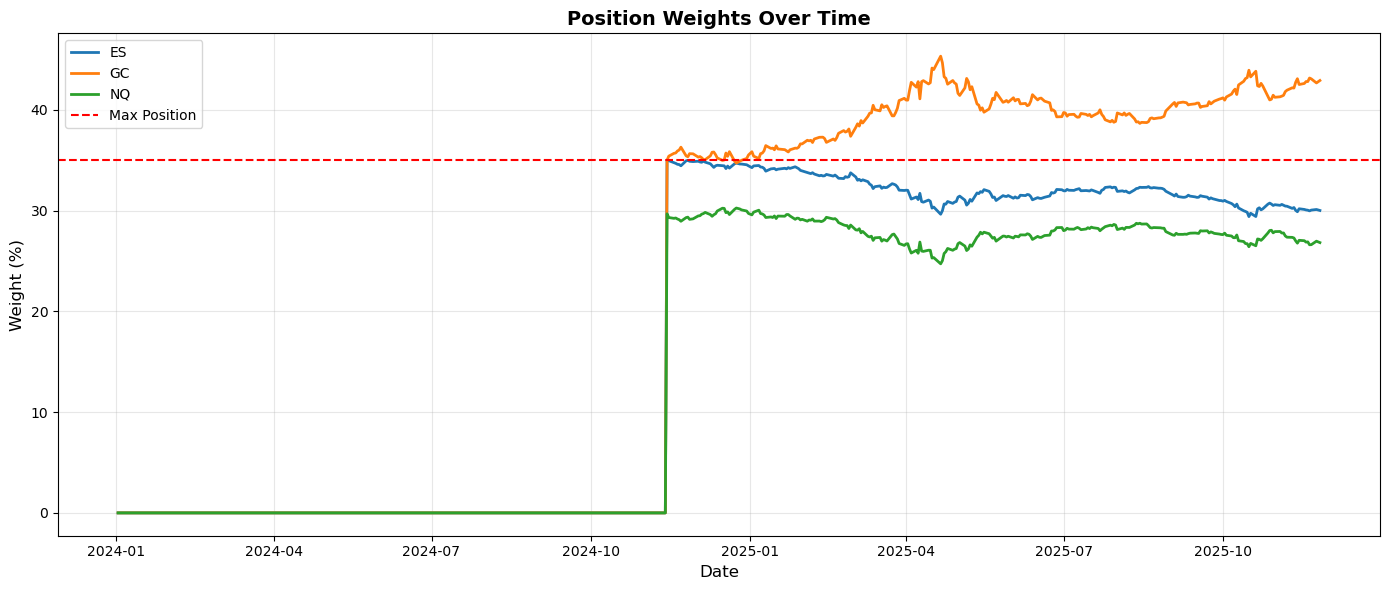


✅ Position analysis complete


In [17]:
# Extract position weights over time
position_history = []
for record in equity_df.itertuples():
    positions = record.Positions
    row = {'Date': record.Date}
    for ticker, pos in positions.items():
        # Use 'Weight' (capital W) to match the actual key in positions dict
        row[ticker] = pos.get('Weight', 0)
    position_history.append(row)

pos_df = pd.DataFrame(position_history)

# Plot position weights
fig, ax = plt.subplots(figsize=(14, 6))

for ticker in prices.keys():
    if ticker in pos_df.columns:
        ax.plot(pos_df['Date'], pos_df[ticker] * 100, label=ticker, linewidth=2)

ax.axhline(y=risk_config.max_position_size * 100, color='red', linestyle='--', label='Max Position')
ax.set_title('Position Weights Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weight (%)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Position analysis complete")

---

## 🎓 Key Takeaways

### Complete Backtest Flow:

```
1. Data → 2. Signals → 3. Risk → 4. Portfolio → 5. Results
   ↓           ↓           ↓          ↓             ↓
 Prices    Long/Flat   Sizing    Trades      Metrics
```

### Daily Loop:

```python
for date in dates:
    # 1. Update prices → positions values change
    pm.update_positions(prices)
    
    # 2. Check signals → execute trades
    pm.update_signals(signals, prices, date)
    
    # 3. Check drift → rebalance if needed
    if pm.check_rebalance_needed():
        pm.rebalance(prices, signals, date)
    
    # 4. Record state
    pm.record_equity(date)
```

### Risk Integration:

| When | What | How |
|------|------|-----|
| Before Trade | Check drawdown | `rm.check_drawdown_stop()` |
| During Sizing | Adjust weights | `rm.calculate_position_size()` |
| After Trade | Update state | `rm.update_drawdown()` |
| Rebalance | Check correlation | `rm.calculate_correlation()` |

### Performance Attribution:

```
Total Return = Strategy Return - Transaction Costs
             = Σ(position_returns) - Σ(trade_costs)
```

### Critical Insights:

1. **State Management:**
   - Portfolio state updates EVERY day (prices change)
   - Trades happen ONLY on signal changes
   - Rebalance happens ONLY on drift > threshold

2. **Transaction Costs:**
   - Every trade costs money (3 bps default)
   - More trades = higher costs = lower returns
   - Rebalancing has a cost/benefit tradeoff

3. **Risk vs Return:**
   - Tighter position limits = lower return potential
   - Stricter drawdown stops = capital preservation
   - Balance depends on strategy goals

---

## ✅ Next Step

**Open: `05_walk_forward_framework.ipynb`**

Learn how to avoid overfitting with proper out-of-sample testing!